In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
from itertools import combinations

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.dummy import DummyRegressor

from scipy.spatial.distance import euclidean
from scipy.stats import norm, pearsonr, zscore

import torch
from pytorch_tabnet.tab_model import TabNetRegressor

from transformers import AutoModel, AutoTokenizer

import pickle
from datetime import datetime


In [2]:
'''
file_path_static = 'bondsearch_18_03_2024.xlsx'
bond_data = pd.read_excel(file_path_static)
'''

"\nfile_path_static = 'bondsearch_18_03_2024.xlsx'\nbond_data = pd.read_excel(file_path_static)\n"

In [3]:
'''
quotes_dir = 'quotes/'
dataframes_dict = {}

for filename in tqdm(os.listdir(quotes_dir), desc="Processing files"):
    if filename.endswith('.xlsx'):
        file_path = os.path.join(quotes_dir, filename)
        try:
            df = pd.read_excel(file_path, header=1, engine='openpyxl')
            isin_key = df['ISIN'].iloc[0]
            dataframes_dict[isin_key] = df
        except Exception as e:
            print(f"Не удалось прочитать файл {filename}: {e}")

bond_data = bond_data[bond_data['ISIN'].isin(dataframes_dict.keys())]
dataframes_dict = {key: val for key, val in dataframes_dict.items() if key in bond_data['ISIN'].tolist()}

print(f"Размер отфильтрованных данных bond_data: {bond_data.shape}")
print(f"Количество отфильтрованных ключей в dataframes_dict: {len(dataframes_dict)}")
'''



'\nquotes_dir = \'quotes/\'\ndataframes_dict = {}\n\nfor filename in tqdm(os.listdir(quotes_dir), desc="Processing files"):\n    if filename.endswith(\'.xlsx\'):\n        file_path = os.path.join(quotes_dir, filename)\n        try:\n            df = pd.read_excel(file_path, header=1, engine=\'openpyxl\')\n            isin_key = df[\'ISIN\'].iloc[0]\n            dataframes_dict[isin_key] = df\n        except Exception as e:\n            print(f"Не удалось прочитать файл {filename}: {e}")\n\nbond_data = bond_data[bond_data[\'ISIN\'].isin(dataframes_dict.keys())]\ndataframes_dict = {key: val for key, val in dataframes_dict.items() if key in bond_data[\'ISIN\'].tolist()}\n\nprint(f"Размер отфильтрованных данных bond_data: {bond_data.shape}")\nprint(f"Количество отфильтрованных ключей в dataframes_dict: {len(dataframes_dict)}")\n'

In [4]:
'''
import pickle

with open('dataframes_dict.pickle', 'wb') as handle:
    pickle.dump(dataframes_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Словарь dataframes_dict успешно сохранен.")
'''

'\nimport pickle\n\nwith open(\'dataframes_dict.pickle\', \'wb\') as handle:\n    pickle.dump(dataframes_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)\n\nprint("Словарь dataframes_dict успешно сохранен.")\n'

In [5]:
'''
with open('dataframes_dict.pickle', 'rb') as handle:
    loaded_dataframes_dict = pickle.load(handle)

print("Словарь dataframes_dict успешно загружен.")
'''

'\nwith open(\'dataframes_dict.pickle\', \'rb\') as handle:\n    loaded_dataframes_dict = pickle.load(handle)\n\nprint("Словарь dataframes_dict успешно загружен.")\n'

In [6]:
'''

def safe_mode(s):
    modes = s.mode()
    if len(modes) > 0:
        return modes.iloc[0]
    else:
        return pd.NA

def aggregate_df(df):
    numeric_cols = df.select_dtypes(include=['number']).columns
    categorical_cols = df.select_dtypes(exclude=['number', 'datetime64[ns]']).columns
    
    aggregated_numeric = df.groupby('Дата')[numeric_cols].mean()
    
    aggregated_categorical = df.groupby('Дата')[categorical_cols].agg(safe_mode) # мб не нужно
    
    aggregated_df = pd.concat([aggregated_numeric, aggregated_categorical], axis=1)
    return aggregated_df

dataframes_dict = {isin: aggregate_df(df) for isin, df in tqdm(dataframes_dict.items())}

'''

"\n\ndef safe_mode(s):\n    modes = s.mode()\n    if len(modes) > 0:\n        return modes.iloc[0]\n    else:\n        return pd.NA\n\ndef aggregate_df(df):\n    numeric_cols = df.select_dtypes(include=['number']).columns\n    categorical_cols = df.select_dtypes(exclude=['number', 'datetime64[ns]']).columns\n    \n    aggregated_numeric = df.groupby('Дата')[numeric_cols].mean()\n    \n    aggregated_categorical = df.groupby('Дата')[categorical_cols].agg(safe_mode) # мб не нужно\n    \n    aggregated_df = pd.concat([aggregated_numeric, aggregated_categorical], axis=1)\n    return aggregated_df\n\ndataframes_dict = {isin: aggregate_df(df) for isin, df in tqdm(dataframes_dict.items())}\n\n"

In [7]:
'''
# only g-spread and g-spread changes

all_data = pd.DataFrame()

for isin, df in dataframes_dict.items():
    if 'Дата' not in df.columns:
        df = df.reset_index()
    filtered_df = df[['Дата'] + [col for col in df.columns if 'G-spread' in col]].copy()
    filtered_df['ISIN'] = isin  # Добавляем ISIN для идентификации
    all_data = pd.concat([all_data, filtered_df], ignore_index=True)

all_data.to_excel('aggregated_gspread_data.xlsx', index=False) # считать в 
'''

"\n# only g-spread and g-spread changes\n\nall_data = pd.DataFrame()\n\nfor isin, df in dataframes_dict.items():\n    if 'Дата' not in df.columns:\n        df = df.reset_index()\n    filtered_df = df[['Дата'] + [col for col in df.columns if 'G-spread' in col]].copy()\n    filtered_df['ISIN'] = isin  # Добавляем ISIN для идентификации\n    all_data = pd.concat([all_data, filtered_df], ignore_index=True)\n\nall_data.to_excel('aggregated_gspread_data.xlsx', index=False) # считать в \n"

In [8]:
'''
dataframes_dict = {isin: aggregate_df(df) for isin, df in tqdm(dataframes_dict.items())}

all_data_ytm = pd.DataFrame()

for isin, df in dataframes_dict.items():
    if 'Дата' not in df.columns:
        df = df.reset_index()
    filtered_df = df[['Дата'] + [col for col in df.columns if 'YTM Close' in col]].copy()
    filtered_df['ISIN'] = isin  # Добавляем ISIN для идентификации
    all_data_ytm = pd.concat([all_data_ytm, filtered_df], ignore_index=True)

all_data_ytm.to_excel('aggregated_ytm_data.xlsx', index=False)
'''

"\ndataframes_dict = {isin: aggregate_df(df) for isin, df in tqdm(dataframes_dict.items())}\n\nall_data_ytm = pd.DataFrame()\n\nfor isin, df in dataframes_dict.items():\n    if 'Дата' not in df.columns:\n        df = df.reset_index()\n    filtered_df = df[['Дата'] + [col for col in df.columns if 'YTM Close' in col]].copy()\n    filtered_df['ISIN'] = isin  # Добавляем ISIN для идентификации\n    all_data_ytm = pd.concat([all_data_ytm, filtered_df], ignore_index=True)\n\nall_data_ytm.to_excel('aggregated_ytm_data.xlsx', index=False)\n"

In [9]:
file_path = 'aggregated_gspread_data.xlsx' # aggregated_ytm_data.xlsx
quote_column = 'G-spread' # YTM Close
df = pd.read_excel(file_path)
df['Дата'] = pd.to_datetime(df['Дата'])

dataframes_dict = {}

for isin in tqdm(df['ISIN'].unique()):
    isin_data = df[df['ISIN'] == isin].copy()
    isin_data['Полумесяц'] = isin_data['Дата'].apply(lambda x: f"{x.year}-{x.month}-1" if x.day <= 15 else f"{x.year}-{x.month}-2")
    grouped = isin_data.groupby('Полумесяц')[quote_column].mean().reset_index()
    grouped[f'{quote_column}_diff'] = grouped[quote_column].diff()

    # Вычисление z-счетов для абсолютных изменений G-spread
    grouped['z_score'] = zscore(grouped[f'{quote_column}_diff'].fillna(0))
    # Удаление записей, где z-score модуля разности G-spread выше 3
    grouped = grouped[abs(grouped['z_score']) <= 3]
    grouped.drop(columns=['z_score'], inplace=True)

    # Удалим облигации, где изначально были большие выбросы
    if not grouped.empty and not grouped[quote_column].isna().all():
        dataframes_dict[isin] = grouped.dropna(subset=[f'{quote_column}_diff'])
        
# Проходим по всем DataFrame в словаре и удаляем строки с NaN и Inf
for isin, df in dataframes_dict.items():
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    dataframes_dict[isin] = df

dataframes_dict.get('RU000A103S14', pd.DataFrame())

100%|██████████| 1587/1587 [01:17<00:00, 20.48it/s]


Полумесяц    G-spread  G-spread_diff
1   2021-10-2  188.537292       9.527060
2   2021-11-1  171.265746     -17.271546
3   2021-11-2  210.546291      39.280545
4   2021-12-1  235.398929      24.852637
5   2021-12-2  196.389541     -39.009388
6    2021-9-2  192.717333      -3.672208
7    2022-1-1  131.820204     -60.897129
8    2022-1-2  155.790945      23.970741
9   2022-10-1  293.494199     137.703254
10  2022-10-2  186.990717    -106.503482
11  2022-11-1  235.676721      48.686005
12  2022-11-2  260.981468      25.304747
13  2022-12-1  342.325297      81.343828
14  2022-12-2  343.659443       1.334147
15   2022-2-1  201.632136    -142.027307
16   2022-2-2  372.155814     170.523678
17   2022-3-1  560.827378     188.671564
18   2022-3-2  626.376238      65.548859
20   2022-4-2  772.181447    -236.140124
22   2022-5-2  489.378745      11.040944
23   2022-6-1  336.508892    -152.869853
24   2022-6-2  380.073039      43.564147
25   2022-7-1  444.966926      64.893887
26   2022-7-2  473.399192      28.432266
27   2022-8-1  423.658532     -49.740660
28   2022-8-2  358.469166     -65.189366
29   2022-9-1  283.577966     -74.891200
30   2022-9-2  361.606486      78.028520
31   2023-1-1  295.032376     -66.574109
32   2023-1-2  311.394896      16.362519
33  2023-10-1  220.813152     -90.581744
34  2023-10-2  241.437001      20.623849
35  2023-11-1  232.442656      -8.994345
36  2023-11-2  300.321539      67.878883
37  2023-12-1  282.147316     -18.174224
38  2023-12-2  250.833054     -31.314262
39   2023-2-1  344.482416      93.649363
40   2023-2-2  320.667493     -23.814923
41   2023-3-1  296.556669     -24.110825
42   2023-3-2  273.609899     -22.946770
43   2023-4-1  330.239874      56.629975
44   2023-4-2  325.583885      -4.655989
45   2023-5-1  335.495480       9.911595
46   2023-5-2  296.498140     -38.997339
47   2023-6-1  277.171876     -19.326264
48   2023-6-2  242.064683     -35.107193
49   2023-7-1  276.609850      34.545167
50   2023-7-2  259.719852     -16.889998
51   2023-8-1  198.680615     -61.039237
52   2023-8-2  154.244819     -44.435796
53   2023-9-1  129.807939     -24.436880
54   2023-9-2  119.909475      -9.898463
55   2024-1-1  158.609957      38.700481
56   2024-1-2  213.980363      55.370406
57   2024-2-1  220.897254       6.916891
58   2024-2-2  153.692699     -67.204556
59   2024-3-1  133.696111     -19.996588
60   2024-3-2   96.101439     -37.594672

In [10]:
file_path_static = 'bondsearch_18_03_2024.xlsx'
bond_data = pd.read_excel(file_path_static)
bond_data = bond_data[bond_data['ISIN'].isin(dataframes_dict.keys())]
bond_data.head()

Бумага  Страна          Эмитент  SPV         Сектор  \
0                  РЖД, БО-05  Россия              РЖД  NaN  Корпоративный   
1           Транснефть, БО-07  Россия       Транснефть  NaN  Корпоративный   
31  Сбербанк России, 001P-50R  Россия  Сбербанк России  NaN  Корпоративный   
33          Роснефть, 002P-07  Россия         Роснефть  NaN  Корпоративный   
34        МегаФон, БО-002P-02  Россия          МегаФон  NaN  Корпоративный   

                      Отрасль Валюта       Статус Ранг облигации  \
0   Железнодорожный транспорт    RUB  В обращении      Undefined   
1    Трубопроводный транспорт    RUB  В обращении      Undefined   
31                      Банки    RUB     Погашена      Undefined   
33       Нефтегазовая отрасль    RUB  В обращении      Undefined   
34   Связь и телекоммуникация    RUB  В обращении      Undefined   

                                                Купон  ...  \
0   1-14 купоны - 10.3% годовых, 15-18 купон - 9.3...  ...   
1   1-14 купоны - 8.75% годовых, 15-20 купоны - ст...  ...   
31                         1-11 купоны – 8.8% годовых  ...   
33  1-20 купоны – 8.7% годовых, 21-40 купоны – ста...  ...   
34                         1-14 купоны – 8.9% годовых  ...   

       Номер программы  Cbonds id эмитента Индикативная цена, %  \
0                  NaN                1402                  NaN   
1                  NaN                2535                  NaN   
31      401481B001P02E                 313                  NaN   
33  4-00122-A-002P-02E                 123                  NaN   
34  4-00822-J-002P-02E                 768                  NaN   

   Индикативная доходность, % Дюрация, дней  Дата торгов Биржа  \
0                         NaN           NaN          NaT   NaN   
1                         NaN           NaN          NaT   NaN   
31                        NaN           NaN          NaT   NaN   
33                        NaN           NaN          NaT   NaN   
34                        NaN           NaN          NaT   NaN   

    Модифицированная дюрация  Срок до погашения, лет  G-spread, бп  
0                        NaN                     NaN           NaN  
1                        NaN                     NaN           NaN  
31                       NaN                     NaN           NaN  
33                       NaN                     NaN           NaN  
34                       NaN                     NaN           NaN  

[5 rows x 71 columns]

In [11]:
bond_data = bond_data[bond_data['Тип ставки'] == 'Фиксированная']

In [12]:
bond_data = bond_data[~bond_data['Дополнительная информация'].str.contains('Замещ', na=False)]

In [13]:
bond_data = bond_data[~bond_data['Периодичность выплаты купонов'].isnull()]

In [14]:
bond_data['Базовая ставка'] = bond_data['Базовая ставка'].fillna('')
bond_data_filtered = bond_data[~bond_data['Базовая ставка'].str.contains('Инфляция|инфляция', na=False)]

In [15]:
bond_data.drop(['Бумага', 'Страна', 'SPV', 'Сектор', 'Валюта', 'Листинг', 
                'ISIN 144A', 'Рег. номер', 'CUSIP / CUSIP RegS', 'CUSIP 144A', 'Cbonds ID', 
                'WKN', 'WKN 144A', 'Номер программы', 'Биржа', 'Cbonds id эмитента', 'Метод расчета НКД', 'Анонсированный объём',
                'Объем размещения', 'Объем в обращении', 'Объем в обращении по непогашенному номиналу', 'Эквивалент в USD',
                'Лот кратности', 'Непогашенный номинал', 'Доходность первичного размещения, %', 'Участники сделки', 'Условия конвертации',
                'Дополнительная информация', 'Рейтинг эмитента в ин.валюте M/S&P/F', 'Рейтинг эмиссии в ин.валюте M/S&P/F', 
                'Рейтинг эмитента в нац.валюте M/S&P/F', 'Рейтинг эмиссии в нац.валюте M/S&P/F', 'Ближайшеее доразмещение', 'Начало размещения', 'Окончание размещения', 
                'Начало начисления купонов', 'Начало обращения', 'Регистрация', 'Регистрация программы', 'Индикативная цена, %', 'Индикативная доходность, %',
                'Дюрация, дней', 'Модифицированная дюрация', 'Срок до погашения, лет', 'Дата торгов', 'G-spread, бп'], axis=1, inplace=True, errors='ignore') # мб не удалять Текущий купон, %

In [16]:
bond_data['Secured'] = bond_data['Ранг облигации'].apply(lambda x: 1 if 'Secured' in x else 0)
bond_data['Subordinated'] = bond_data['Ранг облигации'].apply(lambda x: 1 if 'Subordinated' in x else 0)
bond_data.drop('Ранг облигации', axis=1, inplace=True)

In [17]:
def classify_coupon(text):
    # Проверка на NaN или нестроковые значения
    if pd.isnull(text) or not isinstance(text, str):
        return "Неопределено"
    
    # Проверка на наличие неизвестных условий
    if "ставку определяет эмитент" in text or "не указана" in text or "ставку определяет" in text:
        return "Есть хотя бы один неизвестный купон"
    
    # Проверка на наличие формул или условий для переменной ставки
    variable_patterns = [
        r"\+", r"-", r"max", r"min", r"R \+", r"Сj =", r"С =", "GCurve", "ИПЦ", "Ключевая ставка Банка России",
        "по формуле", "букбилдинга", "конкурса"
    ]
    if any(re.search(pattern, text, re.IGNORECASE) for pattern in variable_patterns):
        return "Переменный купон"
    
    # Проверка на полностью фиксированный купон
    if re.search(r"\d+-\d+ купоны - \d+(\.\d+)?% годовых", text):
        return "Полностью фиксированный купон"
    
    return "Неопределено"

bond_data['Классификация купона'] = bond_data['Купон'].apply(classify_coupon)

bond_data = bond_data.drop(columns=['Купон'], inplace=False)

In [18]:
bond_data['Количество наблюдений'] = bond_data['ISIN'].apply(lambda x: len(dataframes_dict[x]))

bond_data['Маржа'] = bond_data['Маржа'].fillna(0, inplace=False)

bond_data['Текущий купон, %'] = bond_data['Текущий купон, %'].fillna(0, inplace=False) # иногда коменчу

bond_data['Цена первичного размещения, %'] = bond_data['Цена первичного размещения, %'].fillna(100, inplace=False)

In [19]:
bond_data['Бессрочная'] = np.where(bond_data['Погашение'].isna(), 1, 0)

In [20]:
reference_date = pd.Timestamp('2024-03-18') # Дата скачивания данных

bond_data['Погашение'] = bond_data[['Погашение', 'Оферта (put)', 'Оферта (call)']].min(axis=1)

bond_data['Дней до погашения'] = (bond_data['Погашение'] - reference_date).dt.days
bond_data.drop(['Погашение'], axis=1, inplace=True)

In [21]:
bond_data['Оферта (put)'] = bond_data['Оферта (put)'].notna().astype(int)
bond_data['Оферта (call)'] = bond_data['Оферта (call)'].notna().astype(int)

In [22]:
rating_values = {
    # АКРА Ratings
    'AAA(RU)': 20, 'AA+(RU)': 19, 'AA(RU)': 18, 'AA-(RU)': 17,
    'A+(RU)': 16, 'A(RU)': 15, 'A-(RU)': 14,
    'BBB+(RU)': 13, 'BBB(RU)': 12, 'BBB-(RU)': 11,
    'BB+(RU)': 10, 'BB(RU)': 9, 'BB-(RU)': 8,
    'B+(RU)': 7, 'B(RU)': 6, 'B-(RU)': 5,
    'AAA(ru.sf)': 20,  # Special case
    'Withdrawn': 0, '-': 0,
    
    # Эксперт РА Ratings
    'ruAAA': 20, 'ruAA+': 19, 'ruAA': 18, 'ruAA-': 17,
    'ruA+': 16, 'ruA': 15, 'ruA-': 14,
    'ruBBB+': 13, 'ruBBB': 12, 'ruBBB-': 11,
    'ruBB+': 10, 'ruBB': 9, 'ruBB-': 8,
    'ruB+': 7, 'ruB': 6, 'ruB-': 5,
    'ruAAA.sf': 20, 'ruA+.sf': 16, 'ruA-.sf': 14,  # Special financial stability ratings
}

def get_rating_value(rating):
    return rating_values.get(rating, 0)
    
def min_rating(row):
    ratings = [row['Рейтинг эмитента АКРА'], row['Рейтинг эмитента Эксперт РА'], 
               row['Рейтинг эмиссии АКРА'], row['Рейтинг эмиссии Эксперт РА']]
    
    filtered_ratings = [r for r in ratings if r not in ['-', 'Withdrawn']]
    
    if not filtered_ratings:
        return rating_values['-']
    
    numeric_values = [get_rating_value(r) for r in filtered_ratings]
    min_value = min(numeric_values)
    
    return min_value

bond_data['Числовой Рейтинг'] = bond_data.apply(min_rating, axis=1)

bond_data.drop(['Рейтинг эмитента АКРА', 'Рейтинг эмитента Эксперт РА', 
                'Рейтинг эмиссии АКРА', 'Рейтинг эмиссии Эксперт РА'], axis=1, inplace=True)

In [23]:
pd.set_option('display.max_columns', 31)

bond_data.head()

Эмитент                    Отрасль       Статус  Текущий купон, %  \
0               РЖД  Железнодорожный транспорт  В обращении              9.30   
1        Транснефть   Трубопроводный транспорт  В обращении              8.75   
31  Сбербанк России                      Банки     Погашена              0.00   
33         Роснефть       Нефтегазовая отрасль  В обращении              8.70   
34          МегаФон   Связь и телекоммуникация  В обращении              8.90   

    Периодичность выплаты купонов     Тип ставки Базовая ставка  Маржа  \
0                             2.0  Фиксированная                   0.0   
1                             2.0  Фиксированная                   0.0   
31                            2.0  Фиксированная                   0.0   
33                            4.0  Фиксированная                   0.0   
34                            2.0  Фиксированная                   0.0   

   Способ выплаты процентов  Номинал / мин. торговый лот        Тип  \
0                  Купонные                       1000.0  Облигации   
1                  Купонные                       1000.0  Облигации   
31                 Купонные                       1000.0  Облигации   
33                 Купонные                       1000.0  Облигации   
34                 Купонные                       1000.0  Облигации   

       Специальный вид  Цена первичного размещения, % Конвертируемые  \
0   Биржевые облигации                          100.0            Нет   
1   Биржевые облигации                          100.0            Нет   
31  Биржевые облигации                          100.0            Нет   
33  Биржевые облигации                          100.0            Нет   
34  Биржевые облигации                          100.0            Нет   

   Условия досрочного выкупа  Оферта (put)  Оферта (call)          ISIN  \
0                        NaN             1              0  RU000A0JWD57   
1                        NaN             1              0  RU000A0JXPK4   
31                       NaN             0              0  RU000A0ZZXS2   
33                       NaN             1              0  RU000A1008Q9   
34                       NaN             0              0  RU000A1009A1   

    Secured  Subordinated                 Классификация купона  \
0         0             0  Есть хотя бы один неизвестный купон   
1         0             0  Есть хотя бы один неизвестный купон   
31        0             0                     Переменный купон   
33        0             0  Есть хотя бы один неизвестный купон   
34        0             0                     Переменный купон   

    Количество наблюдений  Бессрочная  Дней до погашения  Числовой Рейтинг  
0                       0           0                389                20  
1                       0           0                 32                20  
31                      0           0                -11                20  
33                      1           0                 16                20  
34                      0           0                749                20

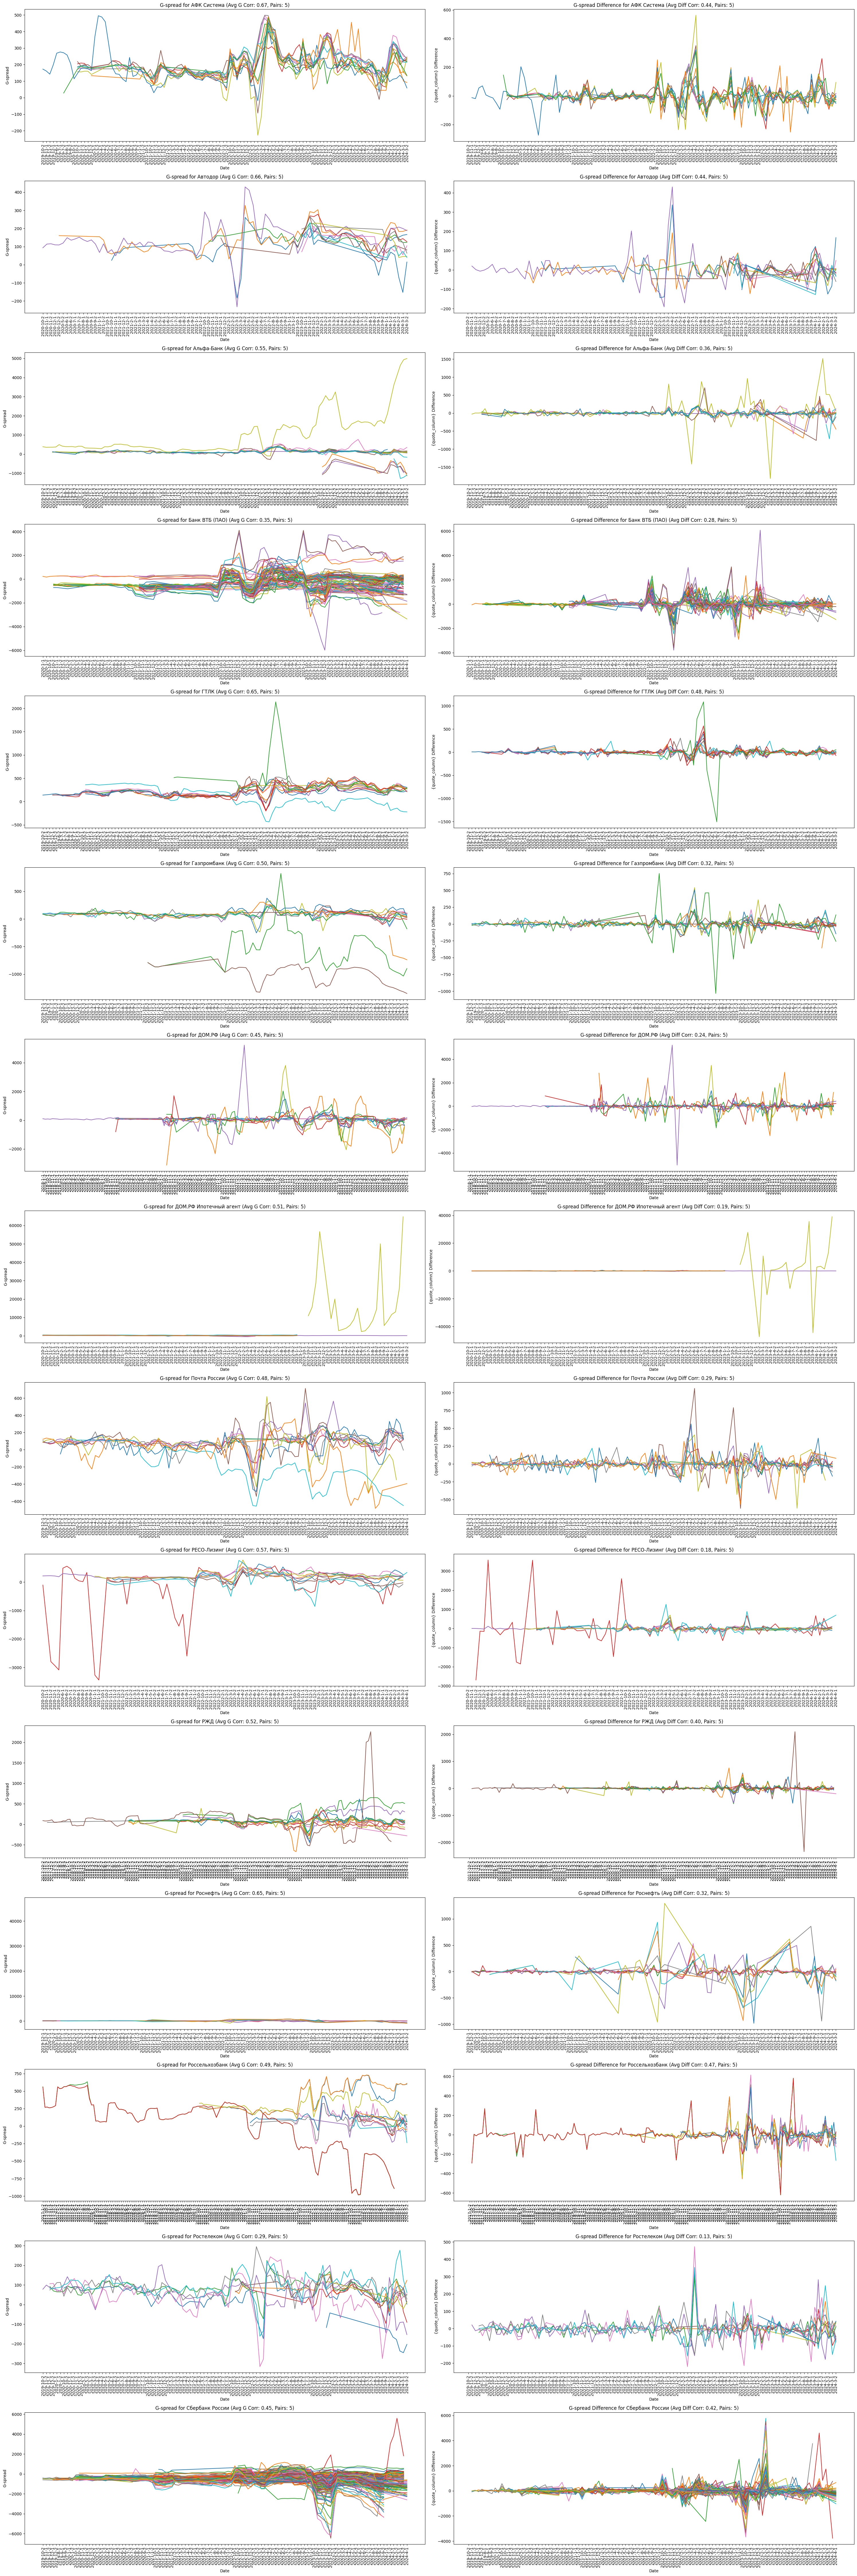

In [24]:
emitter_to_isins = bond_data.groupby('Эмитент')['ISIN'].apply(list).to_dict()
emitter_to_isins_filtered = {k: v for k, v in emitter_to_isins.items() if len(v) >= 10}

filtered_emitter_to_isins = {
    emitter: [isin for isin in isins if isin in dataframes_dict]
    for emitter, isins in emitter_to_isins_filtered.items()
}

num_emitters = len(filtered_emitter_to_isins)
fig, axes = plt.subplots(nrows=num_emitters, ncols=2, figsize=(30, 6 * num_emitters))

if num_emitters == 1:
    axes = [axes]

for ax_row, (emitter, isins) in zip(axes, filtered_emitter_to_isins.items()):
    ax_gspread, ax_diff = ax_row

    unique_halfmonths = sorted(set(sum([dataframes_dict[isin]['Полумесяц'].unique().tolist() for isin in isins], [])))
    halfmonth_to_idx = {hm: idx for idx, hm in enumerate(unique_halfmonths)}

    ax_gspread.set_xticks(range(len(unique_halfmonths)))
    ax_gspread.set_xticklabels(unique_halfmonths, rotation=90)
    ax_diff.set_xticks(range(len(unique_halfmonths)))
    ax_diff.set_xticklabels(unique_halfmonths, rotation=90)

    g_correlations = []
    diff_correlations = []
    valid_pairs_count = 0
    max_valid_pairs = 5

    pair_list = list(combinations(isins, 2))
    random.shuffle(pair_list)  # Перемешиваем список пар

    for isin1, isin2 in pair_list:
        if valid_pairs_count >= max_valid_pairs:
            break  # Останавливаемся, если нашли достаточно пар
        df1, df2 = dataframes_dict[isin1], dataframes_dict[isin2]
        common_halfmonths = set(df1['Полумесяц']).intersection(df2['Полумесяц'])
        if common_halfmonths:
            common_data1 = df1[df1['Полумесяц'].isin(common_halfmonths) & df1[f'{quote_column}_diff'].notna()].sort_values('Полумесяц').reset_index(drop=True)
            common_data2 = df2[df2['Полумесяц'].isin(common_halfmonths) & df2[f'{quote_column}_diff'].notna()].sort_values('Полумесяц').reset_index(drop=True)
            
            if len(common_data1) == len(common_data2) and len(common_data1) > 15:
                corr, _ = pearsonr(common_data1[quote_column], common_data2[quote_column])
                diff_corr, _ = pearsonr(common_data1[f'{quote_column}_diff'], common_data2[f'{quote_column}_diff'])
                
                g_correlations.append(corr)
                diff_correlations.append(diff_corr)
                valid_pairs_count += 1

    avg_g_corr = np.mean(g_correlations) if g_correlations else np.nan
    avg_diff_corr = np.mean(diff_correlations) if diff_correlations else np.nan

    for isin in isins:
        df = dataframes_dict[isin].copy()  # Создаем копию DataFrame перед изменениями
        df[f'{quote_column}_diff'] = df[quote_column].diff()
        df['HalfMonthIdx'] = df['Полумесяц'].map(halfmonth_to_idx)
        ax_gspread.plot(df['HalfMonthIdx'], df[quote_column])
        ax_diff.plot(df['HalfMonthIdx'], df[f'{quote_column}_diff'])


    ax_gspread.set_title(f'{quote_column} for {emitter} (Avg G Corr: {avg_g_corr:.2f}, Pairs: {valid_pairs_count})')
    ax_gspread.set_xlabel('Date')
    ax_gspread.set_ylabel(f'{quote_column}')
    
    ax_diff.set_title(f'{quote_column} Difference for {emitter} (Avg Diff Corr: {avg_diff_corr:.2f}, Pairs: {valid_pairs_count})')
    ax_diff.set_xlabel('Date')
    ax_diff.set_ylabel('{quote_column} Difference')

plt.tight_layout()
plt.show()


кол-во пар с совпадением эмитентов: 26046 кол-во пар с разными эмитентами: 67590


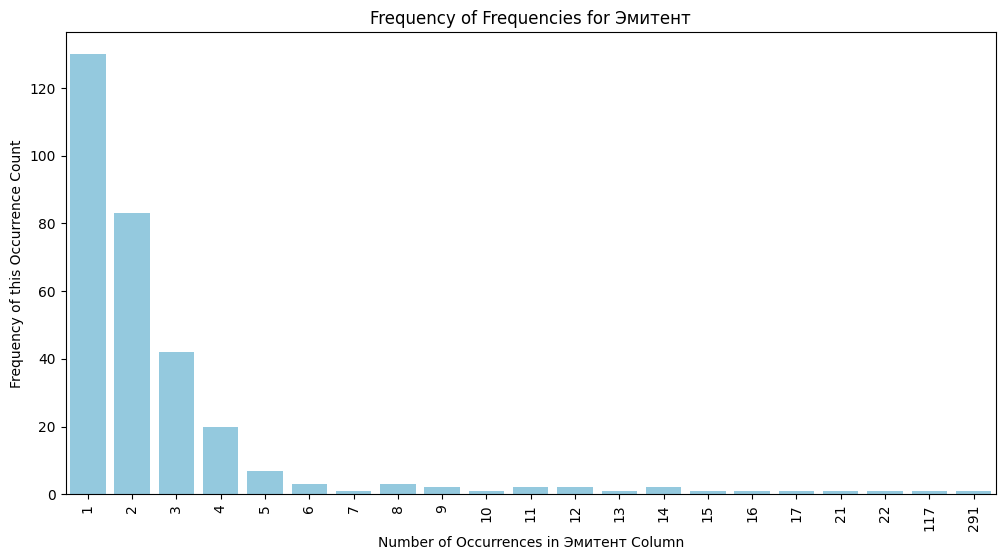

In [25]:
emitter_counts = bond_data['Эмитент'].value_counts()

frequency_of_frequencies = emitter_counts.value_counts()

sum_of_squares = sum(value ** 2 for value in frequency_of_frequencies)

sum_of_products = sum(value * (sum(frequency_of_frequencies) - value) for value in frequency_of_frequencies)

print(f'кол-во пар с совпадением эмитентов: {sum_of_squares}', f'кол-во пар с разными эмитентами: {sum_of_products}')

plt.figure(figsize=(12, 6))
sns.barplot(x=frequency_of_frequencies.index, y=frequency_of_frequencies.values, color='skyblue')
plt.title('Frequency of Frequencies for Эмитент')
plt.xlabel('Number of Occurrences in Эмитент Column')
plt.ylabel('Frequency of this Occurrence Count')
plt.xticks(rotation=90)
plt.show()

In [57]:
categorical_features = [
    'Эмитент', 'Отрасль', 'Статус', 'Тип ставки', 'Базовая ставка',
    'Способ выплаты процентов', 'Тип', 'Специальный вид', 'Конвертируемые',
    'Условия досрочного выкупа', 'Оферта (put)', 'Оферта (call)', 'Классификация купона',
    'Бессрочная', 'Secured', 'Subordinated'
]

numerical_features = [
    'Текущий купон, %', 'Периодичность выплаты купонов', 'Маржа', 'Номинал / мин. торговый лот',
    'Цена первичного размещения, %', 'Количество наблюдений', 'Дней до погашения', 'Числовой Рейтинг' # Текущий купон, %
]

In [93]:
# Создаем папку для сохранения графиков, если она не существует
output_dir = 'graphs'
os.makedirs(output_dir, exist_ok=True)

# Полный список признаков
full_feature_list = numerical_features + categorical_features

# Признаки, которые нужно исключить
features_to_exclude = ['Эмитент', 'Условия досрочного выкупа']  # слишком много значений

# Фильтруем признаки
filtered_features = [feature for feature in full_feature_list if feature not in features_to_exclude]

# Сохраняем каждый график в отдельный файл с порядковым номером
for idx, feature in enumerate(filtered_features, start=1):
    plt.figure(figsize=(10, 6))
    
    # Строим гистограмму для численных признаков
    if not isinstance(bond_data[feature].dropna().iloc[0], str):
        plt.hist(bond_data[feature].dropna(), bins=50, edgecolor='black')
        plt.title(f'Histogram for {feature}')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        file_name = f'{output_dir}/histogram_{idx}.png'
    # Строим столбчатую диаграмму для категориальных признаков
    else:
        sns.countplot(x=bond_data[feature].dropna())
        plt.title(f'Count plot for {feature}')
        plt.xlabel(feature)
        plt.xticks(rotation=90)
        plt.ylabel('Count')
        file_name = f'{output_dir}/countplot_{idx}.png'

    # Сохраняем график
    plt.tight_layout()
    plt.savefig(file_name)
    plt.close()


In [28]:
industry_to_group = {
    'Железнодорожный транспорт': 'Транспорт',
    'Трубопроводный транспорт': 'Транспорт',
    'Нефтегазовая отрасль': 'Энергетика',
    'Утилизация и удаление отходов': 'Услуги',
    'Электроэнергетика': 'Энергетика',
    'Черная металлургия': 'Промышленность',
    'Производство автотранспорта': 'Промышленность',
    'Перевозки сухопутным транспортом': 'Транспорт',
    'Недвижимость и фонды недвижимости': 'Услуги',
    'Лизинг и аренда': 'Услуги',
    'Банки': 'Финансовые услуги',
    'Снабжение водой, теплом, газом': 'Энергетика',
    'Холдинги': 'Финансовые услуги',
    'Связь и телекоммуникация': 'Телекоммуникации',
    'Строительство сооружений': 'Строительство',
    'Прочие финансовые институты': 'Финансовые услуги',
    'Удобрения': 'Промышленность',
    'Институты развития и государственные агентства': 'Финансовые услуги',
    'Целлюлозно-бумажная и деревообрабатывающая': 'Промышленность',
    'Производство летательных аппаратов и вооружения': 'Промышленность',
    'Производство лекарств и биотехнологии': 'Здравоохранение',
    'Вспомогательная транспортная деятельность': 'Транспорт',
    'Добыча драгоценных металлов': 'Промышленность',
    'Специализированная розничная торговля': 'Торговля',
    'Оптовая торговля': 'Торговля',
    'АПК и сельское хозяйство': 'Прочее',
    'Финансовые рынки': 'Финансовые услуги',
    'Цветная металлургия': 'Промышленность',
    'Производство продуктов и напитков': 'Промышленность',
    'Почтовая и курьерская служба': 'Услуги',
    'ИТ сервисы и программное обеспечение': 'Телекоммуникации',
    'FMCG ретейл': 'Торговля',
    'Прочее машиностроение и приборостроение': 'Промышленность',
    'Воздушный транспорт': 'Транспорт',
    'Химическая и нефтехимическая промышленность': 'Промышленность',
    'Строительство зданий': 'Строительство',
    'Микрофинансирование': 'Финансовые услуги',
    'Оборудование и услуги для добычи нефти и газа': 'Энергетика',
    'Медицинские услуги': 'Здравоохранение',
    'Добыча прочих полезных ископаемых': 'Промышленность',
    'Компьютеры, периферия и комплектующие': 'Промышленность',
    'Производство строительных материалов': 'Промышленность',
    'Телекоммуникационное оборудование': 'Телекоммуникации',
    'Общественное питание': 'Услуги',
    'Образование': 'Услуги',
    'Товары длительного пользования': 'Торговля',
    'Изготовление одежды и аксессуаров': 'Промышленность',
    'Полупроводники': 'Промышленность',
    'Добыча угля': 'Энергетика',
    'Другие отрасли': 'Прочее',
    'Онлайн-ретейл': 'Торговля',
    'Персональные и коммерческие услуги': 'Услуги',
    'Медицинское оборудование': 'Здравоохранение',
    'Развлечение и досуг': 'Услуги',
    'Тара и упаковка': 'Промышленность'
}

group_similarity = {
    'Транспорт': {
        'Транспорт': 10,
        'Энергетика': 6,
        'Промышленность': 5,
        'Финансовые услуги': 3,
        'Здравоохранение': 2,
        'Торговля': 5,
        'Строительство': 4,
        'Телекоммуникации': 3,
        'Услуги': 5,
        'Прочее': 3
    },
    'Энергетика': {
        'Транспорт': 6,
        'Энергетика': 10,
        'Промышленность': 7,
        'Финансовые услуги': 4,
        'Здравоохранение': 2,
        'Торговля': 4,
        'Строительство': 5,
        'Телекоммуникации': 3,
        'Услуги': 4,
        'Прочее': 3
    },
    'Промышленность': {
        'Транспорт': 5,
        'Энергетика': 7,
        'Промышленность': 10,
        'Финансовые услуги': 4,
        'Здравоохранение': 3,
        'Торговля': 6,
        'Строительство': 6,
        'Телекоммуникации': 4,
        'Услуги': 5,
        'Прочее': 4
    },
    'Финансовые услуги': {
        'Транспорт': 3,
        'Энергетика': 4,
        'Промышленность': 4,
        'Финансовые услуги': 10,
        'Здравоохранение': 3,
        'Торговля': 5,
        'Строительство': 3,
        'Телекоммуникации': 3,
        'Услуги': 4,
        'Прочее': 4
    },
    'Здравоохранение': {
        'Транспорт': 2,
        'Энергетика': 2,
        'Промышленность': 3,
        'Финансовые услуги': 3,
        'Здравоохранение': 10,
        'Торговля': 3,
        'Строительство': 3,
        'Телекоммуникации': 4,
        'Услуги': 5,
        'Прочее': 3
    },
    'Торговля': {
        'Транспорт': 5,
        'Энергетика': 4,
        'Промышленность': 6,
        'Финансовые услуги': 5,
        'Здравоохранение': 3,
        'Торговля': 10,
        'Строительство': 4,
        'Телекоммуникации': 3,
        'Услуги': 6,
        'Прочее': 5
    },
    'Строительство': {
        'Транспорт': 4,
        'Энергетика': 5,
        'Промышленность': 6,
        'Финансовые услуги': 3,
        'Здравоохранение': 3,
        'Торговля': 4,
        'Строительство': 10,
        'Телекоммуникации': 3,
        'Услуги': 5,
        'Прочее': 4
    },
    'Телекоммуникации': {
        'Транспорт': 3,
        'Энергетика': 3,
        'Промышленность': 4,
        'Финансовые услуги': 3,
        'Здравоохранение': 4,
        'Торговля': 3,
        'Строительство': 3,
        'Телекоммуникации': 10,
        'Услуги': 5,
        'Прочее': 4
    },
    'Услуги': {
        'Транспорт': 5,
        'Энергетика': 4,
        'Промышленность': 5,
        'Финансовые услуги': 4,
        'Здравоохранение': 5,
        'Торговля': 6,
        'Строительство': 5,
        'Телекоммуникации': 5,
        'Услуги': 10,
        'Прочее': 5
    },
    'Прочее': {
        'Транспорт': 3,
        'Энергетика': 3,
        'Промышленность': 4,
        'Финансовые услуги': 4,
        'Здравоохранение': 3,
        'Торговля': 5,
        'Строительство': 4,
        'Телекоммуникации': 4,
        'Услуги': 5,
        'Прочее': 10
    }
}


set(industry_to_group.values())

{'Здравоохранение',
 'Промышленность',
 'Прочее',
 'Строительство',
 'Телекоммуникации',
 'Торговля',
 'Транспорт',
 'Услуги',
 'Финансовые услуги',
 'Энергетика'}

In [29]:
def create_difference_and_ratio_features(static_data1, static_data2, feature_name):
    difference = static_data1[feature_name] - static_data2[feature_name]
    ratio = np.divide(
        static_data1[feature_name], 
        static_data2[feature_name], 
        out=np.full_like(static_data1[feature_name], np.nan, dtype='float64'),  # Указываем тип данных
        where=static_data2[feature_name] != 0
    )
    return difference, ratio


def check_values_equal(value1, value2):
    return int(value1 == value2)


def remove_outliers(df, column_name):
    """Удаляет выбросы из указанной колонки датафрейма на основе Z-оценки."""
    df = df.copy()
    df['z_score'] = zscore(df[column_name])
    df = df[np.abs(df['z_score']) <= 3]  # обычно используется порог 3 для Z-оценки
    return df.drop(columns=['z_score'])

def process_pairs(data, dataframes_dict, numerical_features, categorical_features, industry_to_group, group_similarity, should_remove_outliers=False):
    rows_list = []

    for isin1 in tqdm(list(data['ISIN'].unique()), desc="Outer Loop"):
        for isin2 in list(data['ISIN'].unique()):
            if isin1 == isin2:
                continue

            static_data1 = data.loc[data['ISIN'] == isin1].iloc[0]
            static_data2 = data.loc[data['ISIN'] == isin2].iloc[0]

            df1 = dataframes_dict.get(isin1)
            df2 = dataframes_dict.get(isin2)

            if df1 is not None and df2 is not None and not df1.empty and not df2.empty:
                if should_remove_outliers:
                    df1 = remove_outliers(df1, f'{quote_column}_diff')
                    df2 = remove_outliers(df2, f'{quote_column}_diff')

                common_dates = set(df1['Полумесяц']).intersection(set(df2['Полумесяц']))
                df1_common = df1[df1['Полумесяц'].isin(common_dates)]
                df2_common = df2[df2['Полумесяц'].isin(common_dates)]

                if len(common_dates) > 15:
                    correlation, _ = pearsonr(df1_common[f'{quote_column}_diff'], df2_common[f'{quote_column}_diff'])

                    row = {'Correlation': correlation}

                    for feature in numerical_features:
                        difference, ratio = create_difference_and_ratio_features(static_data1, static_data2, feature)
                        row[f'{feature}_diff'] = difference
                        row[f'{feature}_ratio'] = ratio

                    for feature in categorical_features:
                        is_equal = check_values_equal(static_data1[feature], static_data2[feature])
                        row[f'{feature}_equal'] = is_equal

                    # Вычисление похожести на основе групп отраслей
                    group1 = industry_to_group.get(static_data1['Отрасль'], 'Прочее')
                    group2 = industry_to_group.get(static_data2['Отрасль'], 'Прочее')
                    row['Похожесть отраслей'] = group_similarity[group1][group2]

                    rows_list.append(row)

    df_result = pd.DataFrame(rows_list)
    return df_result

bond_data_train, bond_data_test = train_test_split(bond_data, test_size=0.2, random_state=42)

df_train = process_pairs(bond_data_train, dataframes_dict, numerical_features, categorical_features, industry_to_group, group_similarity)
df_test = process_pairs(bond_data_test, dataframes_dict, numerical_features, categorical_features, industry_to_group, group_similarity)

Outer Loop: 100%|██████████| 240/240 [01:35<00:00,  2.51it/s]


In [30]:
df_train.to_csv(f'df_train_{quote_column}.csv', index=False)
df_test.to_csv(f'df_test_{quote_column}.csv', index=False)
# Комментированный код для загрузки
# df_train = pd.read_csv('df_train.csv')
# df_test = pd.read_csv('df_test.csv')

In [31]:
missing_columns = df_train.columns[df_train.isnull().any()].tolist()
print("Столбцы с пропущенными значениями:", missing_columns)

Столбцы с пропущенными значениями: []


In [32]:
df_train = df_train[~df_train['Периодичность выплаты купонов_diff'].isnull()]
df_train = df_train[np.isfinite(df_train['Периодичность выплаты купонов_diff'])]

In [47]:
pd.set_option('display.max_columns', 50)
display(df_train.head(), len(df_train))

Correlation  Текущий купон, %_diff Текущий купон, %_ratio  \
0     0.516237                   2.65     1.2560386473429952   
1     0.258214                  12.99                 1300.0   
2     0.539478                  -1.50      0.896551724137931   
3     0.115909                  10.00      4.333333333333333   
4     0.121745                  12.99                 1300.0   

   Периодичность выплаты купонов_diff Периодичность выплаты купонов_ratio  \
0                                 2.0                                 2.0   
1                                 3.0                                 4.0   
2                                -8.0                  0.3333333333333333   
3                                 2.0                                 2.0   
4                                 3.0                                 4.0   

   Маржа_diff Маржа_ratio  Номинал / мин. торговый лот_diff  \
0         0.0         nan                               0.0   
1         0.0         nan                               0.0   
2         0.0         nan                               0.0   
3         0.0         nan                               0.0   
4         0.0         nan                               0.0   

  Номинал / мин. торговый лот_ratio  Цена первичного размещения, %_diff  \
0                               1.0                                 0.0   
1                               1.0                                 0.0   
2                               1.0                                 0.0   
3                               1.0                                 0.0   
4                               1.0                                 0.0   

  Цена первичного размещения, %_ratio  Количество наблюдений_diff  \
0                                 1.0                         -31   
1                                 1.0                          19   
2                                 1.0                          23   
3                                 1.0                         -32   
4                                 1.0                           3   

  Количество наблюдений_ratio  Дней до погашения_diff Дней до погашения_ratio  \
0           0.651685393258427                      67      1.1437768240343347   
1          1.4871794871794872                    -667     0.44416666666666665   
2          1.6571428571428573                     366       3.191616766467066   
3          0.6444444444444445                    -387      0.5793478260869566   
4          1.0545454545454545                   -1157      0.3153846153846154   

   Числовой Рейтинг_diff Числовой Рейтинг_ratio  Эмитент_equal  Отрасль_equal  \
0                    -18                    0.0              0              0   
1                    -20                    0.0              0              0   
2                    -11                    0.0              0              0   
3                    -18                    0.0              0              0   
4                    -20                    0.0              0              0   

   Статус_equal  Тип ставки_equal  Базовая ставка_equal  \
0             1                 1                     1   
1             1                 1                     1   
2             1                 1                     1   
3             1                 1                     1   
4             1                 1                     1   

   Способ выплаты процентов_equal  Тип_equal  Специальный вид_equal  \
0                               1          1                      0   
1                               1          1                      0   
2                               1          1                      0   
3                               1          1                      0   
4                               1          1                      0   

   Конвертируемые_equal  Условия досрочного выкупа_equal  Оферта (put)_equal  \
0                     1                                0                  

607590

In [58]:
numerical_features_diff_ratio = [f"{feature}_diff" for feature in numerical_features] + \
                                [f"{feature}_ratio" for feature in numerical_features] + ['Похожесть отраслей']

categorical_features_equal = [f"{feature}_equal" for feature in categorical_features]

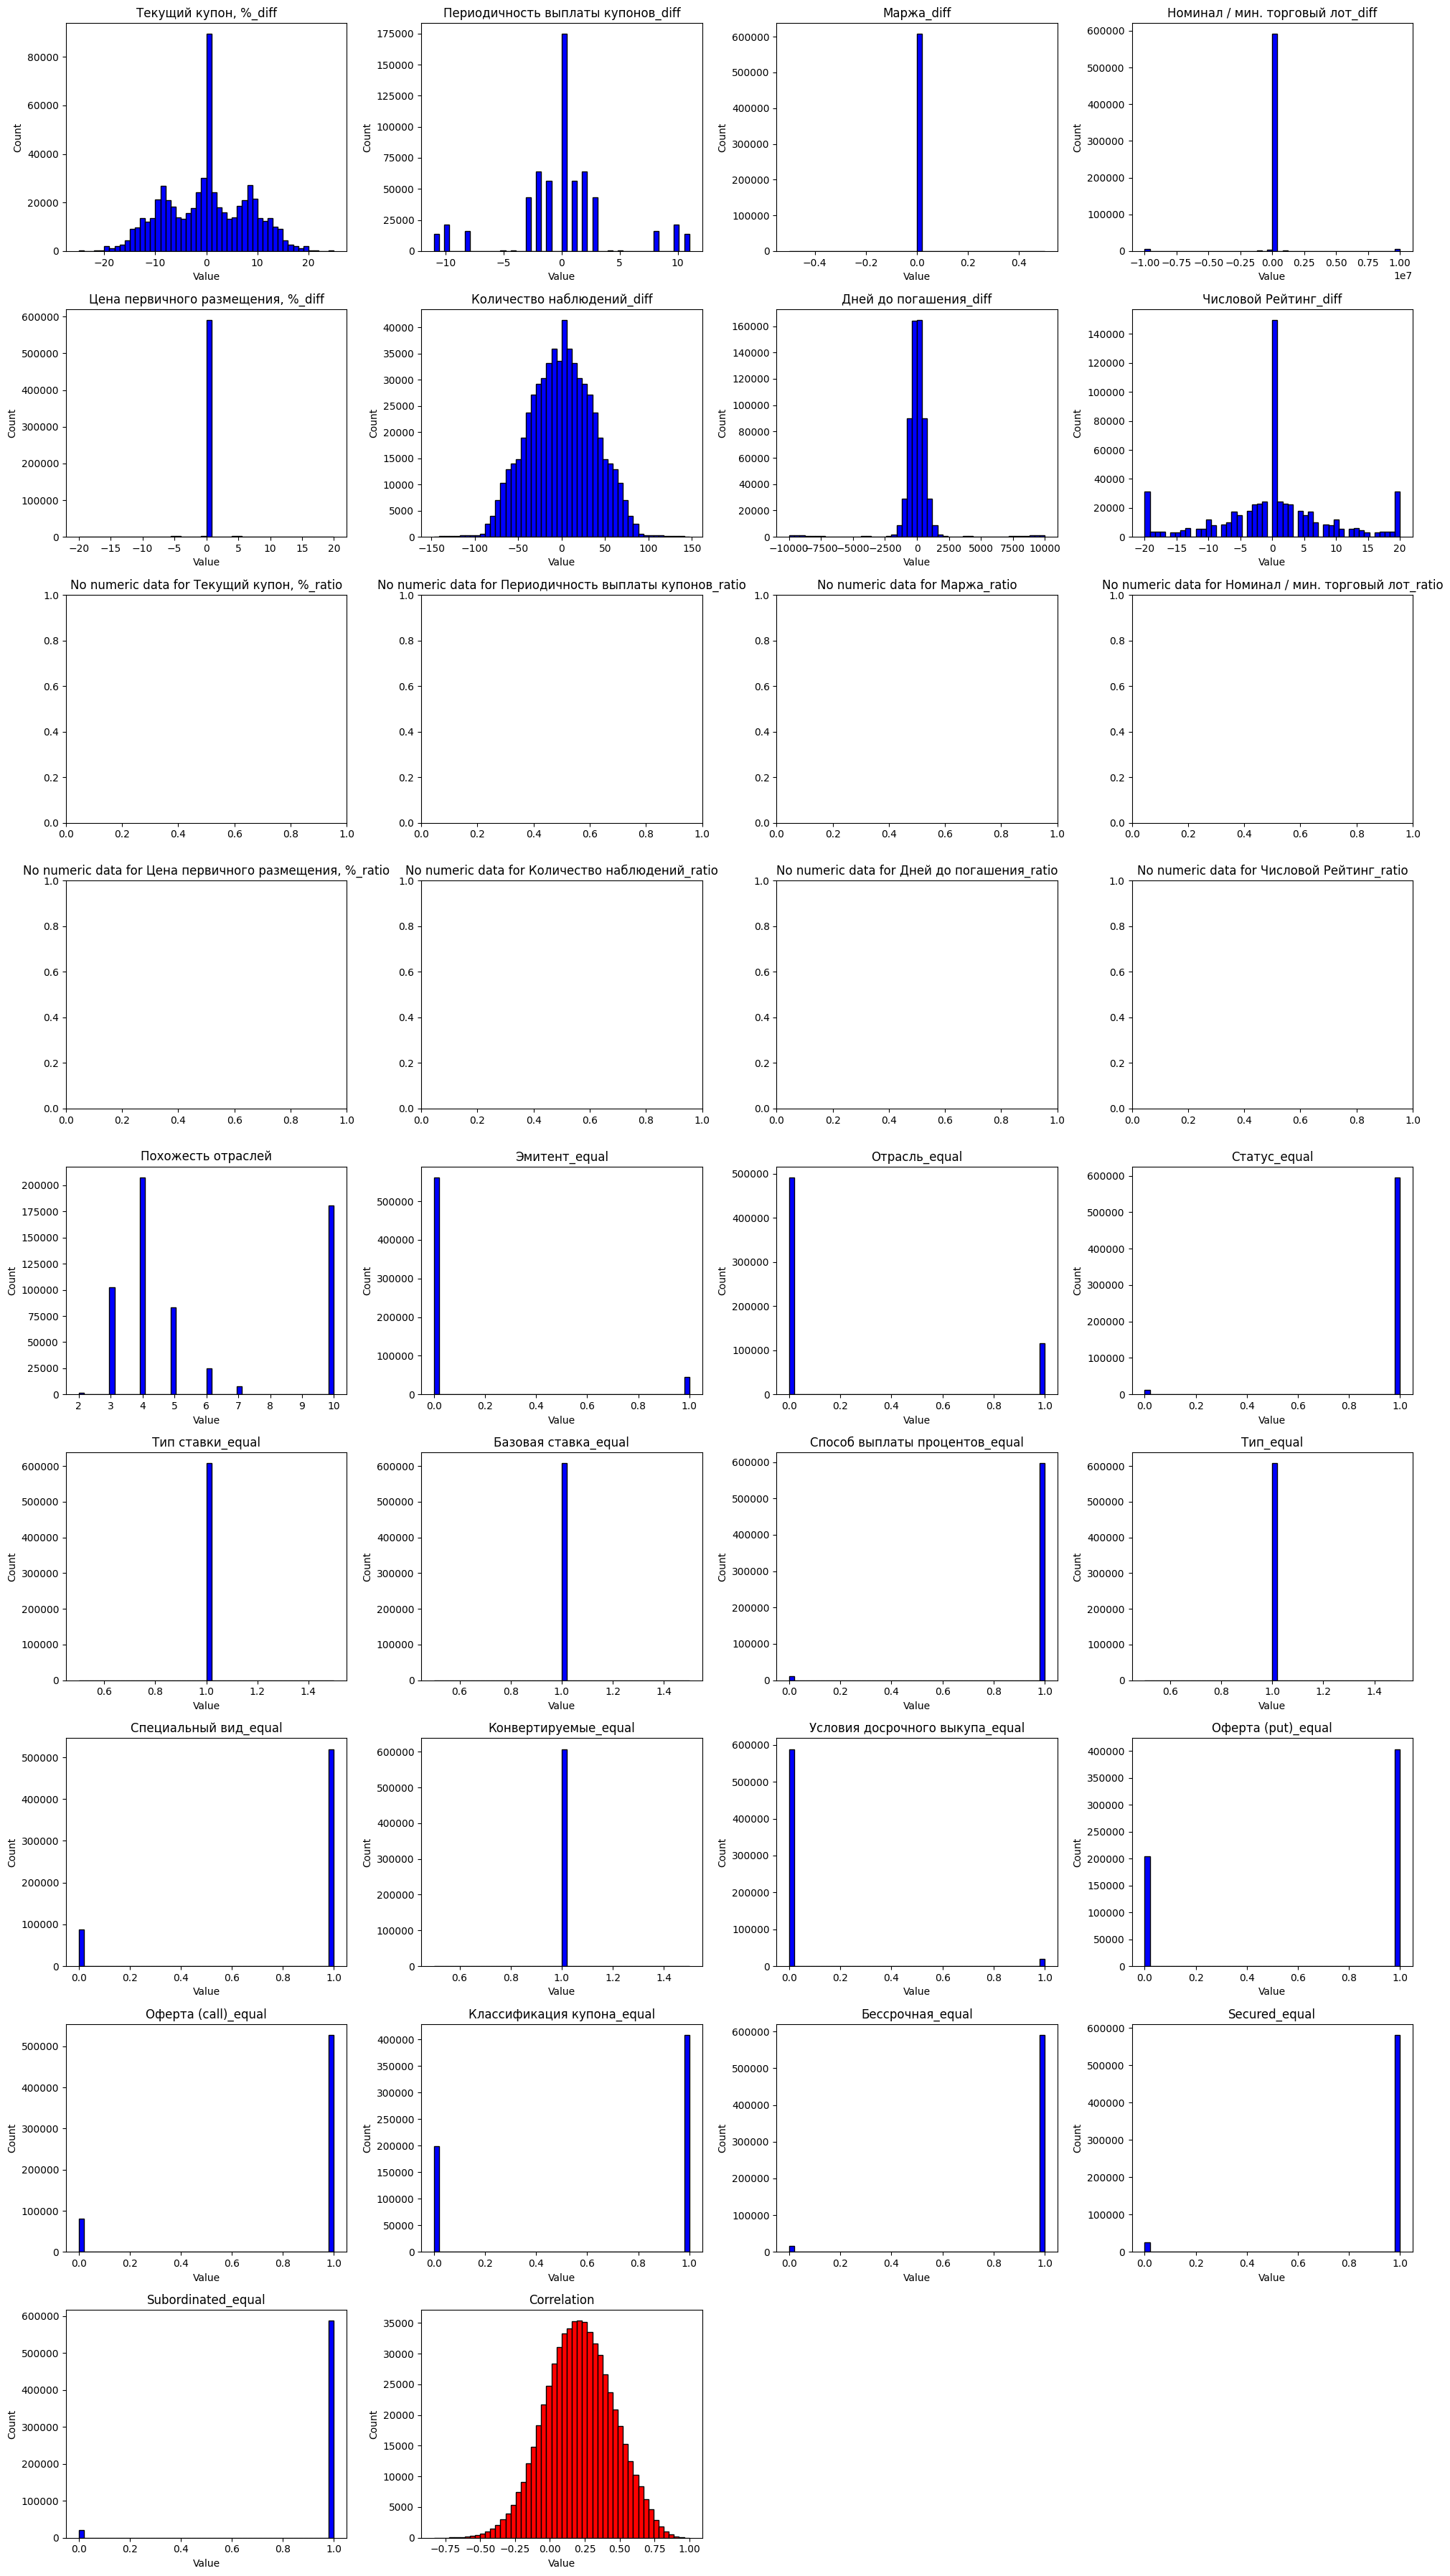

In [35]:
# Почему-то часть графиков пустые ну можно забить на это
total_features = len(numerical_features_diff_ratio) + len(categorical_features_equal) + 1  # +1 for 'Correlation'
cols = 4
rows = (total_features + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))

for i, feature in enumerate(numerical_features_diff_ratio + categorical_features_equal + ['Correlation']):
    ax = axes[i // cols, i % cols]
    color = 'red' if 'Correlation' in feature else 'blue'
    if feature in df_train.columns:
        data = df_train[feature].dropna()
        if pd.api.types.is_numeric_dtype(data):  # Проверяем, является ли столбец числовым
            data = data[np.isfinite(data)]  # Удаляем бесконечные значения
            if not data.empty:  # Проверяем, что после удаления NaN и бесконечностей есть данные для отображения
                ax.hist(data, bins=50, edgecolor='black', color=color)
                ax.set_title(feature)
                ax.set_xlabel('Value')
                ax.set_ylabel('Count')
        else:
            ax.set_title(f"No numeric data for {feature}")
    else:
        ax.set_title(f"{feature} not in df_train")

for k in range(i + 1, rows * cols):
    axes[k // cols, k % cols].axis('off')

plt.tight_layout()
plt.show()

In [36]:
mean_correlation_per_emittent_equal = df_train.groupby('Эмитент_equal')['Correlation'].mean()
print(mean_correlation_per_emittent_equal)

Эмитент_equal
0    0.201707
1    0.312980
Name: Correlation, dtype: float64


In [37]:
def fill_with_max(X, feature_names):
    for feature in feature_names:
        if "ratio" in feature:
            max_value = X[feature].max()
            X[feature] = X[feature].fillna(max_value)
    return X

X_train = fill_with_max(df_train, numerical_features_diff_ratio)
X_test = fill_with_max(df_test, numerical_features_diff_ratio)

y_train = df_train['Correlation']
y_test = df_test['Correlation']

X_train = df_train.drop(['Correlation'], axis=1)
X_test = df_test.drop(['Correlation'], axis=1)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features_diff_ratio),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=-1)), # мб пролблема будет так как missing заменил на -1
            ('onehot', OneHotEncoder(handle_unknown='ignore')) # если с признаками равенства, то не нужно, но и не мешает
        ]), categorical_features_equal)
    ]
)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [38]:
dummy_model = DummyRegressor(strategy="mean")
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100)
gb_model = GradientBoostingRegressor()

dummy_model.fit(X_train_preprocessed, y_train)
lr_model.fit(X_train_preprocessed, y_train)
rf_model.fit(X_train_preprocessed, y_train)
gb_model.fit(X_train_preprocessed, y_train)

y_test_pred_dummy = dummy_model.predict(X_test_preprocessed)
y_test_pred_lr = lr_model.predict(X_test_preprocessed)
y_test_pred_rf = rf_model.predict(X_test_preprocessed)
y_test_pred_gb = gb_model.predict(X_test_preprocessed)

test_mae_dummy = mean_absolute_error(y_test, y_test_pred_dummy)
test_r2_dummy = r2_score(y_test, y_test_pred_dummy)
print("Бейзлайн (среднее значение):")
print(f"Тестовая MAE: {test_mae_dummy}")
print(f"Тестовый R²: {test_r2_dummy}\n")

test_mae_lr = mean_absolute_error(y_test, y_test_pred_lr)
test_r2_lr = r2_score(y_test, y_test_pred_lr)
print("Линейная регрессия:")
print(f"Тестовая MAE: {test_mae_lr}")
print(f"Тестовый R²: {test_r2_lr}\n")

test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)
print("Случайный лес:")
print(f"Тестовая MAE: {test_mae_rf}")
print(f"Тестовый R²: {test_r2_rf}\n")

test_mae_gb = mean_absolute_error(y_test, y_test_pred_gb)
test_r2_gb = r2_score(y_test, y_test_pred_gb)
print("Градиентный бустинг:")
print(f"Тестовая MAE: {test_mae_gb}")
print(f"Тестовый R²: {test_r2_gb}")


Бейзлайн (среднее значение):
Тестовая MAE: 0.2086487408313188
Тестовый R²: -0.000514618186891802

Линейная регрессия:
Тестовая MAE: 0.20376852321002506
Тестовый R²: 0.034945772140777986

Случайный лес:
Тестовая MAE: 0.19238117242742736
Тестовый R²: 0.11919672187817576

Градиентный бустинг:
Тестовая MAE: 0.19303671111103793
Тестовый R²: 0.1232389109733073


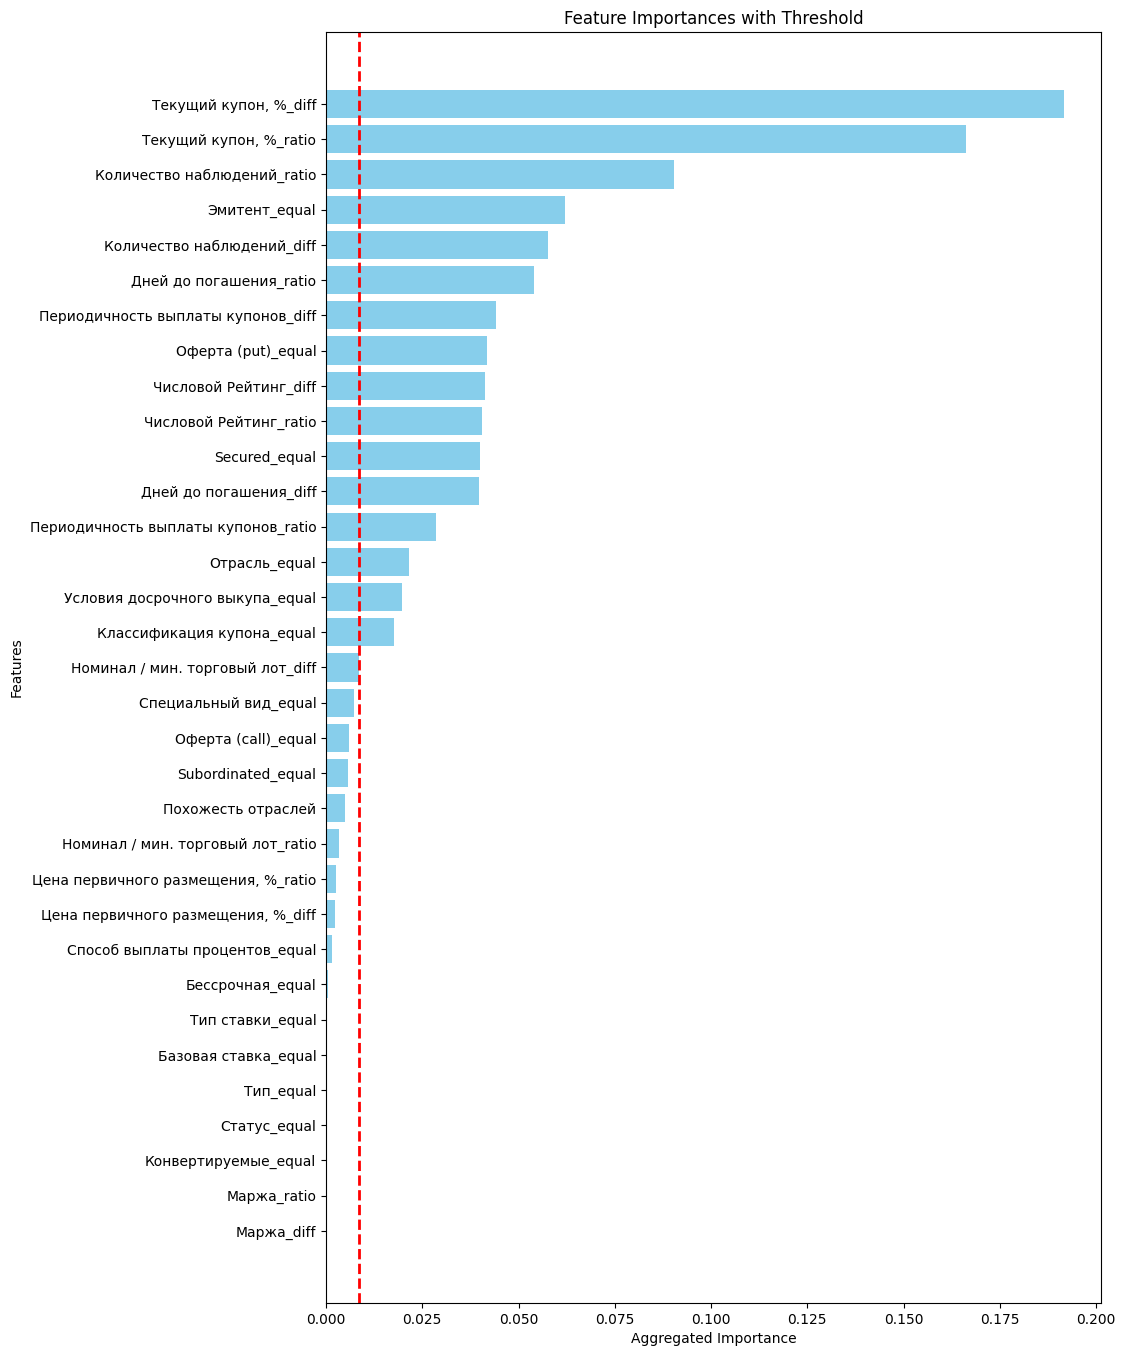

Feature  Aggregated Importance
0                 Текущий купон, %_diff               0.191718
8                Текущий купон, %_ratio               0.166153
13          Количество наблюдений_ratio               0.090493
17                        Эмитент_equal               0.061962
5            Количество наблюдений_diff               0.057761
14              Дней до погашения_ratio               0.054121
1    Периодичность выплаты купонов_diff               0.044171
27                   Оферта (put)_equal               0.041711
7                 Числовой Рейтинг_diff               0.041316
15               Числовой Рейтинг_ratio               0.040559
31                        Secured_equal               0.040035
6                Дней до погашения_diff               0.039770
9   Периодичность выплаты купонов_ratio               0.028649
18                        Отрасль_equal               0.021606
26      Условия досрочного выкупа_equal               0.019845
29           Классификация купона_equal               0.017569
3      Номинал / мин. торговый лот_diff               0.008580
24                Специальный вид_equal               0.007244
28                  Оферта (call)_equal               0.005886
32                   Subordinated_equal               0.005673
16                   Похожесть отраслей               0.004845
11    Номинал / мин. торговый лот_ratio               0.003478
12  Цена первичного размещения, %_ratio               0.002555
4    Цена первичного размещения, %_diff               0.002407
22       Способ выплаты процентов_equal               0.001439
30                     Бессрочная_equal               0.000456
20                     Тип ставки_equal               0.000000
21                 Базовая ставка_equal               0.000000
23                            Тип_equal               0.000000
19                         Статус_equal               0.000000
25                 Конвертируемые_equal               0.000000
10                          Маржа_ratio               0.000000
2                            Маржа_diff               0.000000

In [39]:
original_features = numerical_features_diff_ratio + categorical_features_equal

transformed_features = preprocessor.get_feature_names_out()
importances = gb_model.feature_importances_

feature_importance_mapping = dict(zip(transformed_features, importances))
aggregated_importances = dict.fromkeys(original_features, 0)

for original_feature in original_features:
    for transformed_feature, importance in feature_importance_mapping.items():
        if original_feature in transformed_feature:
            aggregated_importances[original_feature] += importance

aggregated_importances_df = pd.DataFrame(list(aggregated_importances.items()), columns=['Feature', 'Aggregated Importance'])
aggregated_importances_df.sort_values(by='Aggregated Importance', ascending=False, inplace=True)

threshold = aggregated_importances_df['Aggregated Importance'].median()

plt.figure(figsize=(10, len(aggregated_importances_df) / 2))
plt.barh(aggregated_importances_df['Feature'], aggregated_importances_df['Aggregated Importance'], color='skyblue')
plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2)
plt.xlabel('Aggregated Importance')
plt.ylabel('Features')
plt.title('Feature Importances with Threshold')
plt.gca().invert_yaxis()
plt.show()

aggregated_importances_df

In [40]:
# НЕ УДАЛЯТЬ РАБОЧАЯ ЯЧЕЙКА

tabnet_params = {
    'n_d': 16,
    'n_a': 16,
    'n_steps': 3,
    'optimizer_fn': torch.optim.Adam,
    'optimizer_params': dict(lr=2e-2),
    'scheduler_params': {"step_size":10, "gamma":0.9},
    'scheduler_fn': torch.optim.lr_scheduler.StepLR,
    'mask_type': 'entmax'  # Вы можете использовать "sparsemax"
}

tabnet_model = TabNetRegressor(**tabnet_params)

y_train_np = y_train.to_numpy().reshape(-1, 1)
y_test_np = y_test.to_numpy().reshape(-1, 1)

max_epochs = 1000
tabnet_model.fit(
    X_train=X_train_preprocessed, y_train=y_train_np,
    eval_set=[(X_train_preprocessed, y_train_np), (X_test_preprocessed, y_test_np)],
    eval_name=['train', 'valid'],
    eval_metric=['mae'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

y_pred_test = tabnet_model.predict(X_test_preprocessed)

test_mae_tabnet = mean_absolute_error(y_test_np, y_pred_test)
test_r2_tabnet = r2_score(y_test_np, y_pred_test)

print("TabNet:")
print(f"Тестовая MAE: {test_mae_tabnet}")
print(f"Тестовый R²: {test_r2_tabnet}")

# Сохранение модели
tabnet_model.save_model('tabnet_model')

# # Закомментированная ячейка для скачивания модели
# from google.colab import files
# files.download('/path/to/save/tabnet_model.zip')


/usr/local/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.07639 | train_mae: 0.18825 | valid_mae: 0.1997  |  0:00:56s
epoch 1  | loss: 0.05546 | train_mae: 0.18516 | valid_mae: 0.19786 |  0:01:55s
epoch 2  | loss: 0.05399 | train_mae: 0.18323 | valid_mae: 0.19655 |  0:02:53s
epoch 3  | loss: 0.0531  | train_mae: 0.18169 | valid_mae: 0.19488 |  0:03:51s
epoch 4  | loss: 0.05254 | train_mae: 0.18203 | valid_mae: 0.19376 |  0:04:52s
epoch 5  | loss: 0.05199 | train_mae: 0.18072 | valid_mae: 0.19318 |  0:05:49s
epoch 6  | loss: 0.05098 | train_mae: 0.1772  | valid_mae: 0.19157 |  0:06:47s
epoch 7  | loss: 0.05044 | train_mae: 0.1785  | valid_mae: 0.19254 |  0:07:43s
epoch 8  | loss: 0.05011 | train_mae: 0.17813 | valid_mae: 0.1925  |  0:08:40s
epoch 9  | loss: 0.04972 | train_mae: 0.1768  | valid_mae: 0.19223 |  0:09:33s
epoch 10 | loss: 0.04943 | train_mae: 0.17605 | valid_mae: 0.19101 |  0:10:30s
epoch 11 | loss: 0.04905 | train_mae: 0.17557 | valid_mae: 0.19273 |  0:11:26s
epoch 12 | loss: 0.0489  | train_mae: 0.17414 | vali

/usr/local/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet:
Тестовая MAE: 0.18797605139594517
Тестовый R²: 0.14953897173411046


OSError: [Errno 30] Read-only file system: '/path'

In [71]:
bond_data

Эмитент                    Отрасль       Статус  \
0                 РЖД  Железнодорожный транспорт  В обращении   
1          Транснефть   Трубопроводный транспорт  В обращении   
2     Сбербанк России                      Банки     Погашена   
3            Роснефть       Нефтегазовая отрасль  В обращении   
4             МегаФон   Связь и телекоммуникация  В обращении   
...               ...                        ...          ...   
1195   Банк ВТБ (ПАО)                      Банки  В обращении   
1196   Банк ВТБ (ПАО)                      Банки  В обращении   
1197   Банк ВТБ (ПАО)                      Банки  В обращении   
1198   Банк ВТБ (ПАО)                      Банки  В обращении   
1199   Банк ВТБ (ПАО)                      Банки  В обращении   

      Текущий купон, %  Периодичность выплаты купонов     Тип ставки  \
0                 9.30                            2.0  Фиксированная   
1                 8.75                            2.0  Фиксированная   
2                 0.00                            2.0  Фиксированная   
3                 8.70                            4.0  Фиксированная   
4                 8.90                            2.0  Фиксированная   
...                ...                            ...            ...   
1195              0.01                            2.0  Фиксированная   
1196              0.01                            2.0  Фиксированная   
1197              0.01                            2.0  Фиксированная   
1198              0.01                            2.0  Фиксированная   
1199              0.01                            2.0  Фиксированная   

     Базовая ставка  Маржа Способ выплаты процентов  \
0                      0.0                 Купонные   
1                      0.0                 Купонные   
2                      0.0                 Купонные   
3                      0.0                 Купонные   
4                      0.0                 Купонные   
...             ...    ...                      ...   
1195                   0.0                 Купонные   
1196                   0.0                 Купонные   
1197                   0.0                 Купонные   
1198                   0.0                 Купонные   
1199                   0.0                 Купонные   

      Номинал / мин. торговый лот        Тип     Специальный вид  \
0                          1000.0  Облигации  Биржевые облигации   
1                          1000.0  Облигации  Биржевые облигации   
2                          1000.0  Облигации  Биржевые облигации   
3                          1000.0  Облигации  Биржевые облигации   
4                          1000.0  Облигации  Биржевые облигации   
...                           ...        ...                 ...   
1195                       1000.0  Облигации  Биржевые облигации   
1196                       1000.0  Облигации  Биржевые облигации   
1197                       1000.0  Облигации  Биржевые облигации   
1198                       1000.0  Облигации  Биржевые облигации   
1199                       1000.0  Облигации  Биржевые облигации   

      Цена первичного размещения, % Конвертируемые Условия досрочного выкупа  \
0                             100.0            Нет                         0   
1                             100.0            Нет                         0   
2                             100.0            Нет                         0   
3                             100.0            Нет                         0   
4                             100.0            Нет                         0   
...                             ...            ...                       ...   
1195                          100.0            Нет                         0   
1196                          100.0            Нет                         0   
1197                          100.0            Нет                         0   
1198                          100.0            Нет                         0   
1199      

In [90]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression

# Определяем временной диапазон
start_date = datetime(2022, 3, 18)
end_date = datetime(2024, 3, 18)

# Загружаем данные с котировками G-спредов
aggregated_gspread_data = pd.read_excel('aggregated_gspread_data.xlsx')

# Фильтрация данных по дате
aggregated_gspread_data['Дата'] = pd.to_datetime(aggregated_gspread_data['Дата'])
filtered_gspread_data = aggregated_gspread_data[(aggregated_gspread_data['Дата'] >= start_date) & (aggregated_gspread_data['Дата'] <= end_date)]

# Создание копии bond_data
bond_data_copy = bond_data.copy()

# Удаление существующей колонки 'Количество наблюдений' в копии перед пересчетом
if 'Количество наблюдений' in bond_data_copy.columns:
    bond_data_copy = bond_data_copy.drop(columns=['Количество наблюдений'])

# Пересчет количества наблюдений для каждой облигации
obs_counts = filtered_gspread_data['ISIN'].value_counts().reset_index()
obs_counts.columns = ['ISIN', 'Количество наблюдений']
bond_data_copy = bond_data_copy.merge(obs_counts, on='ISIN', how='left').fillna(0)

# Создание словаря данных по ISIN
gspread_dict = {isin: df for isin, df in filtered_gspread_data.groupby('ISIN')}

# Функция для нахождения ближайших аналогов с использованием модели TabNet
def find_closest_analogs(isin, bond_data, model, numerical_features_diff_ratio, categorical_features_equal, industry_to_group, group_similarity, preprocessor, num_analogs=10):
    static_data = bond_data.loc[bond_data['ISIN'] == isin].iloc[0]
    bond_data_filtered = bond_data[bond_data['ISIN'] != isin]
    pairs = []
    for _, row in bond_data_filtered.iterrows():
        pair_data = []
        for feature in numerical_features_diff_ratio:
            if '_diff' in feature:
                original_feature = feature.replace('_diff', '')
                difference, _ = create_difference_and_ratio_features(static_data, row, original_feature)
                pair_data.append(float(difference) if pd.notna(difference) else 0)
            elif '_ratio' in feature:
                original_feature = feature.replace('_ratio', '')
                _, ratio = create_difference_and_ratio_features(static_data, row, original_feature)
                pair_data.append(float(ratio) if pd.notna(ratio) else 0)
        for feature in categorical_features_equal:
            original_feature = feature.replace('_equal', '')
            is_equal = check_values_equal(static_data[original_feature], row[original_feature])
            pair_data.append(is_equal)
        group1 = industry_to_group.get(static_data['Отрасль'], 'Прочее')
        group2 = industry_to_group.get(row['Отрасль'], 'Прочее')
        pair_data.append(group_similarity[group1][group2])
        pairs.append((row['ISIN'], pair_data))

    all_features = numerical_features_diff_ratio + categorical_features_equal + ['Похожесть отраслей']
    unique_features = list(dict.fromkeys(all_features))  # Удаляем дубликаты

    pairs_df = pd.DataFrame([x[1] for x in pairs], columns=unique_features)
    
    # Преобразование данных в числовой формат
    pairs_df = pairs_df.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Предварительная обработка данных
    pairs_df_preprocessed = preprocessor.transform(pairs_df)
    
    correlations = model.predict(pairs_df_preprocessed.astype(np.float32)).flatten()
    sorted_indices = np.argsort(correlations)[::-1]
    closest_analogs = [(pairs[i][0], correlations[i]) for i in sorted_indices[:num_analogs]]
    return closest_analogs

# Определение наиболее ликвидных облигаций за последние два года
most_liquid_bonds = bond_data_copy.nlargest(200, 'Количество наблюдений')

# Выбор 5 облигаций для анализа
selected_isins = most_liquid_bonds.nlargest(10, 'Количество наблюдений')['ISIN'].tolist()

# Функция для вычисления сигмы через регрессию по дельта G-спредам
def compute_sigma_regression(isin, analogs, gspread_dict):
    try:
        current_bond_df = gspread_dict[isin]
    except KeyError:
        print(f"Data for ISIN {isin} not found in gspread_dict")
        return None

    if 'Дата' not in current_bond_df.columns:
        print(f"Column 'Дата' not found in data for ISIN {isin}")
        return None
    
    current_bond_df = current_bond_df.query('Дата >= @start_date & Дата <= @end_date')
    analogs_dfs = []
    
    for analog in analogs:
        try:
            analog_df = gspread_dict[analog[0]]
            if 'Дата' not in analog_df.columns:
                print(f"Column 'Дата' not found in data for analog {analog[0]}")
                continue
            analog_df_filtered = analog_df.query('Дата >= @start_date & Дата <= @end_date')
            analogs_dfs.append(analog_df_filtered)
        except KeyError:
            print(f"Data for analog ISIN {analog[0]} not found in gspread_dict")
            continue

    if not analogs_dfs:
        print(f"No valid analog data found for ISIN {isin}")
        return None
    
    common_dates = set(current_bond_df['Дата'])
    for df in analogs_dfs:
        common_dates = common_dates.intersection(set(df['Дата']))
    
    common_dates = list(common_dates)
    common_dates.sort()

    if not common_dates:
        print(f"No common dates found for ISIN {isin} and its analogs")
        return None

    current_bond_spread = current_bond_df[current_bond_df['Дата'].isin(common_dates)]['G-spread'].values
    analogs_spreads = np.array([df[df['Дата'].isin(common_dates)]['G-spread'].values for df in analogs_dfs])
    
    avg_analogs_spread = np.mean(analogs_spreads, axis=0)
    
    delta_current_bond_spread = np.diff(current_bond_spread)
    delta_avg_analogs_spread = np.diff(avg_analogs_spread)

    min_length = min(len(delta_current_bond_spread), len(delta_avg_analogs_spread))
    delta_current_bond_spread = delta_current_bond_spread[:min_length]
    delta_avg_analogs_spread = delta_avg_analogs_spread[:min_length]
    
    # Удаление NaN значений
    valid_indices = ~np.isnan(delta_current_bond_spread) & ~np.isnan(delta_avg_analogs_spread)
    delta_current_bond_spread = delta_current_bond_spread[valid_indices]
    delta_avg_analogs_spread = delta_avg_analogs_spread[valid_indices]

    if len(delta_current_bond_spread) == 0 or len(delta_avg_analogs_spread) == 0:
        print(f"No valid data for regression for ISIN {isin}")
        return None
    
    # Вывод дельта G-спредов
    #print(f"Delta G-spreads for ISIN {isin}: {delta_current_bond_spread}")
    #print(f"Delta G-spreads for average analogs: {delta_avg_analogs_spread}")
    
    model = LinearRegression().fit(delta_avg_analogs_spread.reshape(-1, 1), delta_current_bond_spread)
    residuals = delta_current_bond_spread - model.predict(delta_avg_analogs_spread.reshape(-1, 1))
    sigma = np.std(residuals) / 10000  # Делим на 10000, так как сигма в процентных пунктах
    
    return sigma

# Использование модели для нахождения ближайших аналогов и вычисление необходимых метрик
for isin in selected_isins:
    analogs = find_closest_analogs(isin, bond_data_copy, tabnet_model, numerical_features_diff_ratio, categorical_features_equal, industry_to_group, group_similarity, preprocessor)
    print(f"Облигация: {isin}")
    print("Ближайшие аналоги:")
    for analog in analogs:
        print(f"  ISIN: {analog[0]}, Корреляция: {analog[1]}")
    sigma = compute_sigma_regression(isin, analogs, gspread_dict)
    if sigma is not None:
        print(f"Сигма (через регрессию по дельта G-спредам): {sigma}")
    print()

Облигация: RU000A1013C9
Ближайшие аналоги:
  ISIN: RU000A1061E4, Корреляция: 0.8401163816452026
  ISIN: RU000A106KY0, Корреляция: 0.8401163816452026
  ISIN: RU000A105GQ6, Корреляция: 0.8401163816452026
  ISIN: RU000A106AQ7, Корреляция: 0.8401163816452026
  ISIN: RU000A1065F2, Корреляция: 0.8401163816452026
  ISIN: RU000A105MD2, Корреляция: 0.8401163816452026
  ISIN: RU000A106E33, Корреляция: 0.8401163816452026
  ISIN: RU000A106TT1, Корреляция: 0.8401163816452026
  ISIN: RU000A106LS0, Корреляция: 0.8401163816452026
  ISIN: RU000A105S87, Корреляция: 0.8401163816452026
No valid data for regression for ISIN RU000A1013C9

Облигация: RU000A1018C8
Ближайшие аналоги:
  ISIN: RU000A106GZ5, Корреляция: 0.832330584526062
  ISIN: RU000A106YD5, Корреляция: 0.7882800102233887
  ISIN: RU000A106YL8, Корреляция: 0.7706997394561768
  ISIN: RU000A105P72, Корреляция: 0.7515597343444824
  ISIN: RU000A106U74, Корреляция: 0.7346600890159607
  ISIN: RU000A1071Q7, Корреляция: 0.6689156889915466
  ISIN: RU000A1